In [1]:
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn

In [2]:
data = pd.read_csv('C:\\Users\\corey\\Desktop\\git\\portfolio\\data_portfolio\\realestate_ml\\data\\houston_houses.csv')
data = data.drop('Unnamed: 0', axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,Private Pool,zip,price
0,3.0,1758.0,7150.0,2.0,0,1.0,1978.0,False,77084,221000.0
1,4.0,2958.0,9400.0,3.0,1,2.0,1980.0,False,77070,359500.0
2,3.0,1120.0,6000.0,2.0,0,1.0,1936.0,False,77008,825000.0
3,3.0,1714.0,5500.0,2.0,0,1.0,1986.0,False,77095,289995.0
4,0.0,1470.0,4895.0,0.0,0,1.0,1977.0,False,77016,280000.0


In [3]:
data.describe()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,year built,zip,price
count,31947.000000,31947.000000,3.194700e+04,31947.000000,31947.000000,31947.000000,31947.000000,31947.000000,3.194700e+04
mean,3.490062,2384.349516,1.130032e+04,2.368642,0.502739,1.721694,2000.489623,77344.695339,5.002466e+05
std,0.966502,1172.923698,4.506365e+04,0.868732,0.561068,23.930095,52.063806,333.327490,5.990412e+05
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000,71075.000000,1.000000e+00
25%,3.000000,1682.000000,1.660000e+03,2.000000,0.000000,1.000000,1984.000000,77089.000000,2.884950e+05
50%,4.000000,2184.000000,6.373000e+03,2.000000,0.000000,1.000000,2011.000000,77379.000000,3.752320e+05
75%,4.000000,2830.000000,8.795500e+03,3.000000,1.000000,2.000000,2022.000000,77493.000000,5.300000e+05
max,11.000000,36245.000000,1.441410e+06,9.000000,9.000000,3306.000000,2022.000000,78950.000000,2.650000e+07


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31947 entries, 0 to 31946
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31947 non-null  float64
 1   Sqft.         31947 non-null  float64
 2   lot Sqft.     31947 non-null  float64
 3   full baths    31947 non-null  float64
 4   half baths    31947 non-null  int64  
 5   stories       31947 non-null  float64
 6   year built    31947 non-null  float64
 7   Private Pool  31947 non-null  bool   
 8   zip           31947 non-null  int64  
 9   price         31947 non-null  float64
dtypes: bool(1), float64(7), int64(2)
memory usage: 2.2 MB


In [5]:
# Convert zip to string to make it a categorical feature

data['zip'] = data['zip'].astype('str')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31947 entries, 0 to 31946
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bedrooms      31947 non-null  float64
 1   Sqft.         31947 non-null  float64
 2   lot Sqft.     31947 non-null  float64
 3   full baths    31947 non-null  float64
 4   half baths    31947 non-null  int64  
 5   stories       31947 non-null  float64
 6   year built    31947 non-null  float64
 7   Private Pool  31947 non-null  bool   
 8   zip           31947 non-null  object 
 9   price         31947 non-null  float64
dtypes: bool(1), float64(7), int64(1), object(1)
memory usage: 2.2+ MB


In [6]:
# Convert year built to "age" of home

data['age'] = data.apply(lambda x: 2022 - x['year built'] + 1 if x['year built'] else 0, axis=1)
data = data.drop(['year built'], axis=1)
data.head()

,bedrooms,Sqft.,lot Sqft.,full baths,half baths,stories,Private Pool,zip,price,age
0,3.0,1758.0,7150.0,2.0,0,1.0,False,77084,221000.0,45.0
1,4.0,2958.0,9400.0,3.0,1,2.0,False,77070,359500.0,43.0
2,3.0,1120.0,6000.0,2.0,0,1.0,False,77008,825000.0,87.0
3,3.0,1714.0,5500.0,2.0,0,1.0,False,77095,289995.0,37.0
4,0.0,1470.0,4895.0,0.0,0,1.0,False,77016,280000.0,46.0


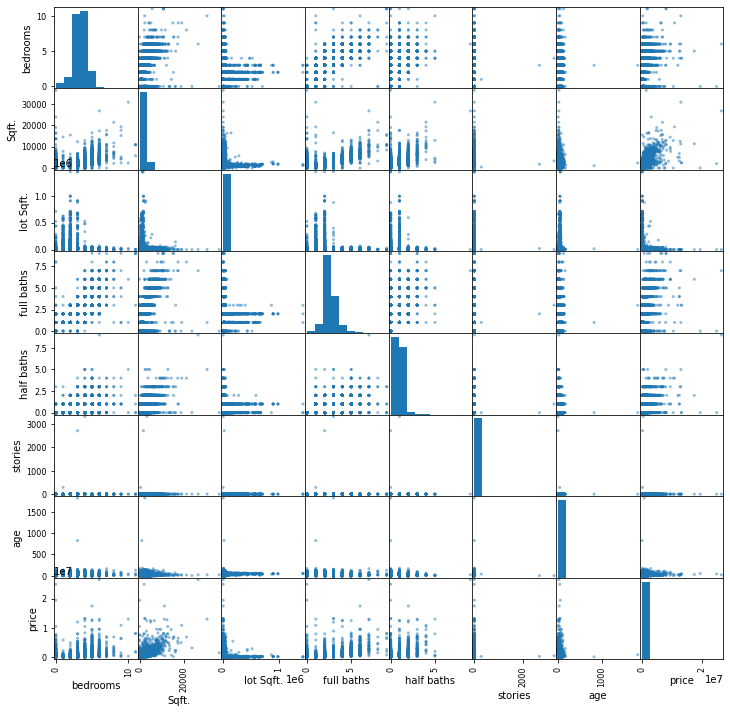

In [7]:
cat_col = ['zip', 'Private Pool']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age', 'price']
scatter_matrix(data[num_col], figsize=(12, 12))
plt.show()

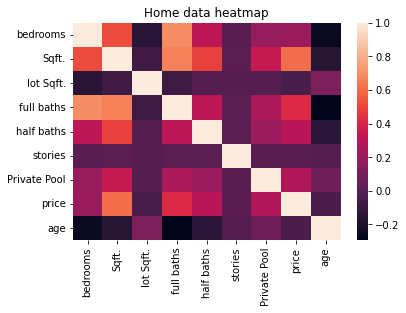

In [8]:
corr = data.corr()

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns).set_title('Home data heatmap')
plt.show()

In [9]:
X = data.drop('price', axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.columns)

Index(['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories',
       'Private Pool', 'zip', 'age'],
      dtype='object')


In [10]:
cat_col = ['zip', 'Private Pool']
num_col = ['bedrooms', 'Sqft.', 'lot Sqft.', 'full baths', 'half baths', 'stories', 'age']

num_pipeline = Pipeline([
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_col),
        ("cat", OneHotEncoder(), cat_col),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [11]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

LinearRegression()

In [12]:
X_test_prepared = full_pipeline.transform(X_test)

lin_reg.score(X_test_prepared, y_test)

0.4585651202304313

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

parameters = {'alpha':(.1, 1, 10, 100), 
              'fit_intercept':(True, False),
              'solver': ('auto', 'lsqr')}

ridge_reg = Ridge()
gs = GridSearchCV(ridge_reg, parameters)
gs.fit(X_train_prepared, y_train)

gs.get_params()


{'cv': None,
 'error_score': nan,
 'estimator__alpha': 1.0,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': None,
 'estimator__normalize': 'deprecated',
 'estimator__positive': False,
 'estimator__random_state': None,
 'estimator__solver': 'auto',
 'estimator__tol': 0.001,
 'estimator': Ridge(),
 'n_jobs': None,
 'param_grid': {'alpha': (0.1, 1, 10, 100),
  'fit_intercept': (True, False),
  'solver': ('auto', 'lsqr')},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [14]:
ridge_regression = Ridge(alpha=1.0, solver='auto')
ridge_regression.fit(X_train_prepared, y_train)
ridge_regression.score(X_test_prepared, y_test)

0.4609944440729943

In [15]:
from sklearn import linear_model

lasso_reg = linear_model.Lasso(alpha=10.0, max_iter=3000, selection='random')
lasso_reg.fit(X_train_prepared, y_train)
lasso_reg.score(X_test_prepared, y_test)

0.45899765068437337

In [16]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                bootstrap=True,
                                n_jobs=1, 
                                random_state=42).fit(X_train_prepared, y_train)
forest.score(X_test_prepared, y_test)   

0.4995047602908196

In [17]:
print(f'coef of determination = {forest.score(X_test_prepared, y_test)}')
print(f'MAE = {mean_squared_error(y_test, forest.predict(X_test_prepared))}')

coef of determination = 0.4995047602908196
MAE = 172238751076.83752
